# Correlated Multi-Asset Tail Risk: VaR, CVaR and Crisis Behaviour

This notebook is a **follow-up** to the foundations notebook.

In the foundations notebook we:
- Built an equally weighted portfolio of 5 large-cap tech stocks (AAPL, MSFT, GOOG, NVDA, AMZN).
- Ignored asset correlations and treated the portfolio as **one univariate series**.
- Computed Value at Risk (VaR) and Conditional VaR (CVaR) using historical data and simple parametric fits.

Here, we focus on **learning** how correlations and multivariate structure affect tail risk.

---

## Learning goals

By the end of this notebook you should be able to:

1. Diagnose **fat tails** and choose between Normal vs Student t distributions.
2. Visualise and interpret **correlation and tail dependence** between assets.
3. Build and compare:
   - An **independent-t** Monte Carlo model (ignores correlations).
   - A **correlated-t** model using a Gaussian copula (preserves correlations).
4. Compare **VaR and CVaR** across models and explain:
   > why ignoring correlations can severely underestimate tail risk.
5. Stress-test the model by checking how its VaR behaves during:
   - The **COVID-19 selloff** (2020).
   - The **2008–2009 financial crisis**.

We continue from notebook 4.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf
import seaborn as sns
import statsmodels.api as sm
plt.style.use("default")

## 1. Data: prices and portfolio returns

We pick a few large US tech stocks, download daily **adjusted close** prices
using `yfinance`, compute **daily returns**, and then form a simple
fixed-weight portfolio.

We will use the portfolio **daily return series** as the basis for VaR and
CVaR.


In [2]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2010-01-01'
end_date   = '2019-12-01'
data = yf.download(tickers, start=start_date,auto_adjust=True,end=end_date)
prices = data["Close"].dropna()  # adjusted close prices

print("Prices shape:", prices.shape)
prices.tail()


[*********************100%***********************]  5 of 5 completed

Prices shape: (2495, 5)


Ticker,AAPL,AMZN,GOOG,MSFT,NVDA
Date,,,,,
2019-11-22,63.162117,87.286003,64.326782,142.032898,5.245225
2019-11-25,64.269585,88.692001,64.890450,143.590042,5.501903
2019-11-26,63.767723,89.847000,65.231110,144.349609,5.397193
2019-11-27,64.624260,90.925499,65.203300,144.625000,5.432039
2019-11-29,64.481918,90.040001,64.804527,143.732483,5.394703


In [3]:
# Daily simple returns
asset_returns = prices.pct_change().dropna()

print("Asset returns shape:", asset_returns.shape)
asset_returns.head()


Asset returns shape: (2494, 5)


Ticker,AAPL,AMZN,GOOG,MSFT,NVDA
Date,,,,,
2010-01-05,0.001729,0.005900,-0.004404,0.000323,0.014603
2010-01-06,-0.015907,-0.018116,-0.025209,-0.006137,0.006396
2010-01-07,-0.001849,-0.017013,-0.023279,-0.010400,-0.019597
2010-01-08,0.006648,0.027077,0.013331,0.006897,0.002161
2010-01-11,-0.008822,-0.024041,-0.001512,-0.012721,-0.014016


In [4]:
# Define simple portfolio weights (meanst sum to 1) 
weights = np.array([1/len(tickers)] * len(tickers)) # equal weights 

# Portfolio daily returns: weighted sum across of asset returns that day.
portfolio_returns = asset_returns.dot(weights)
portfolio_returns = pd.Series(portfolio_returns, index=asset_returns.index, name="Portfolio")
print("Portfolio returns shape:", portfolio_returns.shape)

Portfolio returns shape: (2494,)


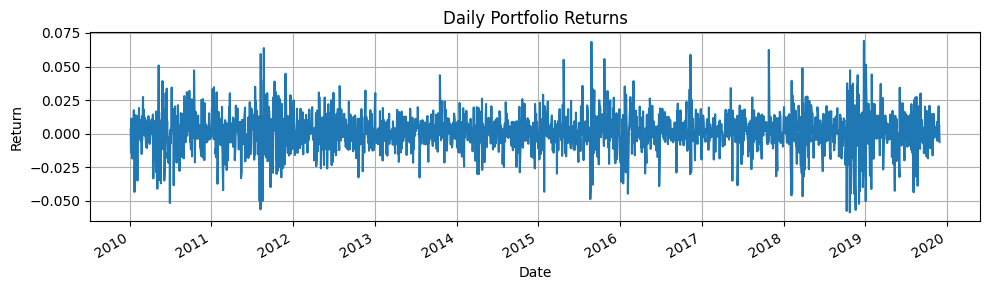

In [5]:
fig, ax = plt.subplots(figsize=(10, 3))
portfolio_returns.plot(ax=ax)
ax.set_title("Daily Portfolio Returns")
ax.set_ylabel("Return")
ax.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# === 4. Normality tests: Shapiro–Wilk and KS ===
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()

print(f"Sample mean: {mean:.6f}")
print(f"Sample std : {std_dev:.6f}")

# Shapiro-Wilk test (use a subset of 5000 points; since Shapiro is O(n^2))

returns_for_shapiro = portfolio_returns.sample(n=min(len(portfolio_returns), 5000), random_state=42)
shapiro_stat, shapiro_p = stats.shapiro(returns_for_shapiro)

print("\nShapiro–Wilk test:")
print(f"  W-statistic: {shapiro_stat:.4f}")
print(f"  p-value    : {shapiro_p:.4g}")

Sample mean: 0.001033
Sample std : 0.013637

Shapiro–Wilk test:
  W-statistic: 0.9610
  p-value    : 2.257e-25


p<0.05; reject null hypothesis of normality

Let us instead fit it to a t-distribution

In [7]:
# Fit Student-t to portfolio returns
df_hat, loc_hat, scale_hat = stats.t.fit(portfolio_returns)

print("Fitted Student-t parameters:")
print("df   =", df_hat)
print("loc  =", loc_hat)
print("scale=", scale_hat)
# === 4. KS ===

# KS test vs fitted Student's t distribution
ks_stat, ks_p = stats.kstest(portfolio_returns, "t", args=(df_hat, loc_hat, scale_hat))

print("\nKolmogorov–Smirnov test vs fitted t:")
print(f"  KS-statistic: {ks_stat:.4f}")
print(f"  p-value     : {ks_p:.4g}")

Fitted Student-t parameters:
df   = 3.461865405423732
loc  = 0.0013415340054427172
scale= 0.00942654769339274

Kolmogorov–Smirnov test vs fitted t:
  KS-statistic: 0.0148
  p-value     : 0.6401


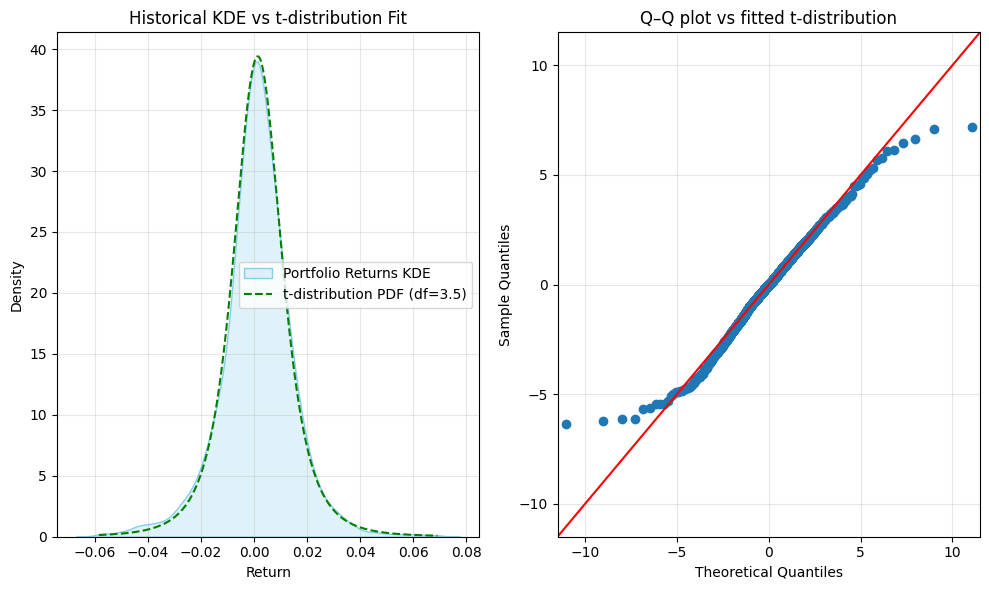

In [8]:
# Compare fit with KDE and normal
fig,ax=plt.subplots(1,2, figsize=(10,6))

x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio Returns KDE',ax=ax[0])
#sns.histplot(portfolio_returns, kde=True, stat='density', color='skyblue', label='Portfolio Returns',ax =ax[0])
ax[0].plot(x, stats.t.pdf(x, df=df_hat, loc=loc_hat, scale=scale_hat), 'g--', label=f't-distribution PDF (df={df_hat:.1f})')
ax[0].set_title("Historical KDE vs t-distribution Fit")
ax[0].set_xlabel("Return")
ax[0].set_ylabel("Density")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 2. Q–Q plot vs fitted t
sm.qqplot(
    portfolio_returns,
    dist=stats.t,           # use Student-t instead of normal
    fit=True,
    line="45",               # 45° reference line
    ax=ax[1]
)
ax[1].set_title("Q–Q plot vs fitted t-distribution")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



The t-distribution with df=3.5 provides a reasonable fit overall, though the extreme negative tail is still heavier than the model suggests.

Lets Calculate the VaR and CVaR

In [9]:
# Convert returns to losses (positive means we lose money)
losses = -portfolio_returns

alpha_values = [0.95, 0.99]

for alpha in alpha_values:
    # Historical VaR: alpha-quantile of losses
    var_alpha = np.quantile(losses, alpha)

    # Historical CVaR: average loss beyond VaR
    tail_losses = losses[losses >= var_alpha]
    cvar_alpha = tail_losses.mean()

    print(f"{int(alpha*100)}% Historical VaR:  {var_alpha:.4%}")
    print(f"{int(alpha*100)}% Historical CVaR: {cvar_alpha:.4%}")
    print()


95% Historical VaR:  2.1539%
95% Historical CVaR: 3.2190%

99% Historical VaR:  3.9845%
99% Historical CVaR: 4.7449%



In [10]:
n_sim = 100_000  # number of Monte Carlo samples for the t model

for alpha in alpha_values:
    # Parametric VaR for returns: t-quantile
    var_return_t = stats.t.ppf(1 - alpha, df=df_hat, loc=loc_hat, scale=scale_hat)
    var_loss_t = -var_return_t

    # Parametric CVaR approximation using Monte Carlo samples
    simulated_returns_t = stats.t.rvs(df_hat, loc_hat, scale_hat, size=n_sim)
    simulated_losses_t = -simulated_returns_t

    var_sim = np.quantile(simulated_losses_t, alpha)
    tail_sim = simulated_losses_t[simulated_losses_t >= var_sim]
    cvar_loss_t = tail_sim.mean()

    print(f"{int(alpha*100)}% Student-t VaR (theoretical):  {var_loss_t:.4%}")
    print(f"{int(alpha*100)}% Student-t CVaR (MC approx.): {cvar_loss_t:.4%}")
    print()


95% Student-t VaR (theoretical):  1.9686%
95% Student-t CVaR (MC approx.): 3.1066%

99% Student-t VaR (theoretical):  3.7215%
99% Student-t CVaR (MC approx.): 5.2175%



So far we:

- created a **portfolio** from multiple assets, then
- worked only with the **aggregate portfolio return series**.
 
If all the stock returns individually follow a t with nearly same d.o.f.s, we would be justified in using a multivariate t dist. to model the total returns. Lets test this:

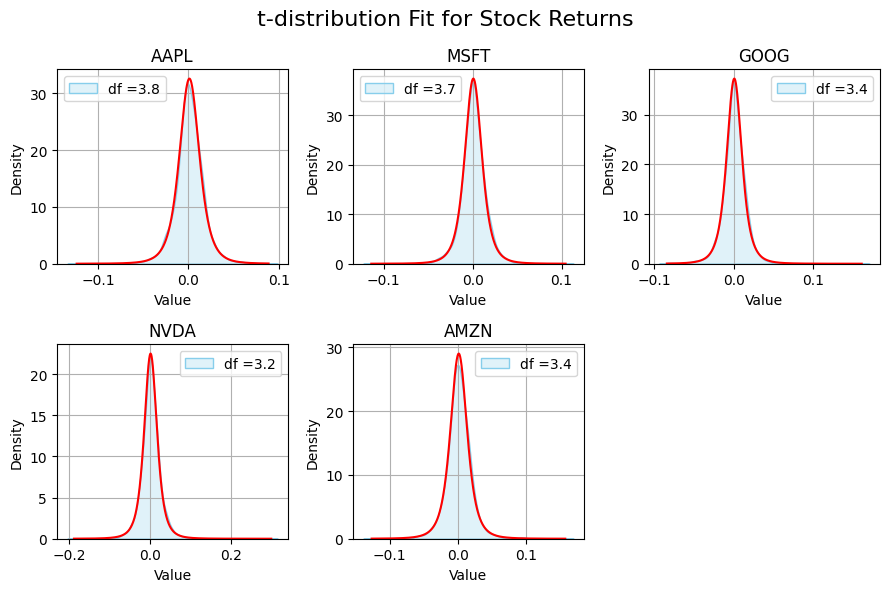

In [11]:
def plot_t_distribution_fit(returns):
    """
    Plot the t-distribution fit against the data. """
    # Create a 2x3 grid but remove the last empty subplot
    fig, ax = plt.subplots(2, 3, figsize=(9, 6))
    plt.suptitle('t-distribution Fit for Stock Returns', fontsize=16)
    # Flatten the axis array for easier indexing
    ax = ax.flatten()
    
    for i, stock in enumerate(tickers):
        data = returns[stock]
        df, loc, scale = stats.t.fit(data)
        x = np.linspace(data.min(), data.max(), 1000)
        
        sns.kdeplot(data, fill=True, color='skyblue', label='Data KDE', ax=ax[i])
        ax[i].plot(x, stats.t.pdf(x, df, loc=loc, scale=scale), 'r-', label=f't-distribution PDF (df={df:.1f})')
        ax[i].set_title(f'{stock}')
        ax[i].set_xlabel('Value')
        ax[i].set_ylabel('Density')
        ax[i].legend([f'df ={df:.1f}'])
        ax[i].grid(True)
    
    # Hide the last empty subplot
    ax[5].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_t_distribution_fit(asset_returns)

In [12]:
# Individual t-distribution simulation approach
print("=== Individual t-Distribution Simulation Approach ===\n")

# Step 1: Fit t-distribution to each stock and store parameters
individual_t_params = {}
print("Fitting t-distributions to individual stocks:")
print("Stock\tdf\tloc\t\tscale")
print("-" * 40)

for stock in tickers:
    df_stock, loc_stock, scale_stock = stats.t.fit(asset_returns[stock])
    individual_t_params[stock] = {'df': df_stock, 'loc': loc_stock, 'scale': scale_stock}
    print(f"{stock}\t{df_stock:.2f}\t{loc_stock:.6f}\t{scale_stock:.6f}")

print(f"\nDegrees of freedom range: {min([params['df'] for params in individual_t_params.values()]):.2f} - {max([params['df'] for params in individual_t_params.values()]):.2f}")

=== Individual t-Distribution Simulation Approach ===

Fitting t-distributions to individual stocks:
Stock	df	loc		scale
----------------------------------------
AAPL	3.77	0.001174	0.011470
MSFT	3.74	0.000748	0.009986
GOOG	3.41	0.000787	0.009959
NVDA	3.25	0.001041	0.016434
AMZN	3.38	0.001204	0.012792

Degrees of freedom range: 3.25 - 3.77


In [13]:
# Step 2: Monte Carlo simulation using individual t-distributions
print("\n=== Monte Carlo Simulation with Individual t-Distributions ===")

n_simulations = 100_000
confidence_level = 0.95

# Initialize array to store simulated portfolio returns
portfolio_returns_individual_t = np.zeros(n_simulations)

# Set random seed for reproducibility
np.random.seed(42)

# For each simulation, generate returns for all stocks and compute portfolio return
for i in range(n_simulations):
    daily_returns = np.zeros(len(tickers))
    
    # Generate return for each stock using its individual t-distribution
    for j, stock in enumerate(tickers):
        params = individual_t_params[stock]
        # Generate one random sample from the t-distribution
        daily_returns[j] = stats.t.rvs(df=params['df'], 
                                loc=params['loc'], 
                                scale=params['scale'])
    
    # Compute portfolio return (equal weights)
    portfolio_returns_individual_t[i] = np.dot(daily_returns, weights)

# Calculate VaR and CVaR
individual_t_VaR = np.percentile(portfolio_returns_individual_t, (1-confidence_level)*100)
individual_t_CVaR = portfolio_returns_individual_t[portfolio_returns_individual_t <= individual_t_VaR].mean()

print(f"Individual t-Distribution Simulation Results ({confidence_level*100:.0f}% confidence):")
print(f"VaR: {-individual_t_VaR:.4f}")
print(f"CVaR: {-individual_t_CVaR:.4f}")
print(f"Number of simulations: {n_simulations:,}")

# Compare with historical measures
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100)
hist_CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()

print(f"\nComparison with Historical:")
print(f"Historical VaR: {-hist_VaR:.4f}")
print(f"Historical CVaR: {-hist_CVaR:.4f}")
print(f"Difference VaR: {individual_t_VaR - hist_VaR:.4f}")
print(f"Difference CVaR: {individual_t_CVaR - hist_CVaR:.4f}")


=== Monte Carlo Simulation with Individual t-Distributions ===
Individual t-Distribution Simulation Results (95% confidence):
VaR: 0.0122
CVaR: 0.0178
Number of simulations: 100,000

Comparison with Historical:
Historical VaR: 0.0215
Historical CVaR: 0.0322
Difference VaR: 0.0094
Difference CVaR: 0.0143


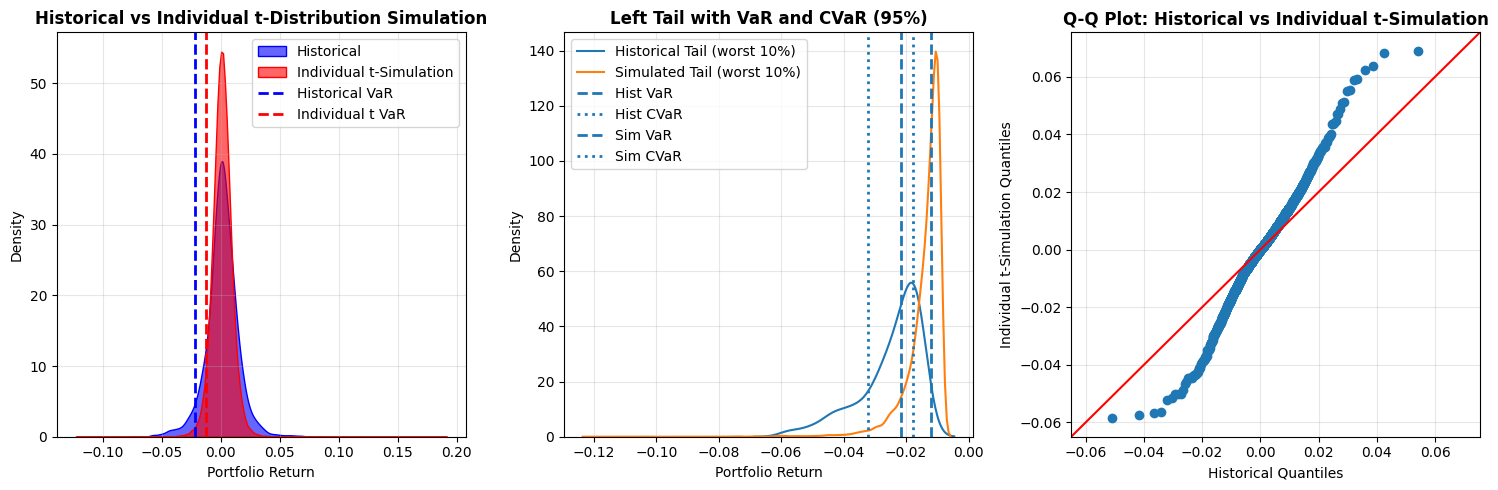

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Distribution comparison
ax1 = axes[0]
sns.kdeplot(portfolio_returns, fill=True, color='blue', alpha=0.6, label='Historical', ax=ax1)
sns.kdeplot(portfolio_returns_individual_t, fill=True, color='red', alpha=0.6, label='Individual t-Simulation', ax=ax1)

# Add VaR lines
ax1.axvline(hist_VaR, color='blue', linestyle='--', linewidth=2, label='Historical VaR')
ax1.axvline(individual_t_VaR, color='red', linestyle='--', linewidth=2, label='Individual t VaR')

ax1.set_title('Historical vs Individual t-Distribution Simulation', fontweight='bold')
ax1.set_xlabel('Portfolio Return')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Q-Q plot
ax3 =  axes[2]  # reuse your existing axes

qqplot_2samples(
    portfolio_returns,                # sample 1: historical
    portfolio_returns_individual_t,   # sample 2: simulated
    line='45',                        # 45° reference line
    ax=ax3
)

ax3.set_title('Q-Q Plot: Historical vs Individual t-Simulation', fontweight='bold')
ax3.set_xlabel('Historical Quantiles')
ax3.set_ylabel('Individual t-Simulation Quantiles')
ax3.grid(True, alpha=0.3)

# Plot 3: Tail comparison with VaR and CVaR
ax2 = axes[1]
# Worst 10% of returns
hist_tail = np.sort(portfolio_returns)[:int(0.1 * len(portfolio_returns))]
sim_tail = np.sort(portfolio_returns_individual_t)[:int(0.1 * len(portfolio_returns_individual_t))]

sns.kdeplot(hist_tail, label='Historical Tail (worst 10%)', ax=ax2)
sns.kdeplot(sim_tail, label='Simulated Tail (worst 10%)', ax=ax2)

# Add VaR / CVaR lines
# You can tweak linestyles so you can distinguish VaR vs CVaR
ax2.axvline(hist_VaR, linestyle='--', linewidth=2, label='Hist VaR')
ax2.axvline(hist_CVaR, linestyle=':',  linewidth=2, label='Hist CVaR')

ax2.axvline(individual_t_VaR, linestyle='--', linewidth=2, label='Sim VaR')
ax2.axvline(individual_t_CVaR, linestyle=':',  linewidth=2, label='Sim CVaR')

ax2.set_title('Left Tail with VaR and CVaR (95%)', fontweight='bold')
ax2.set_xlabel('Portfolio Return')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


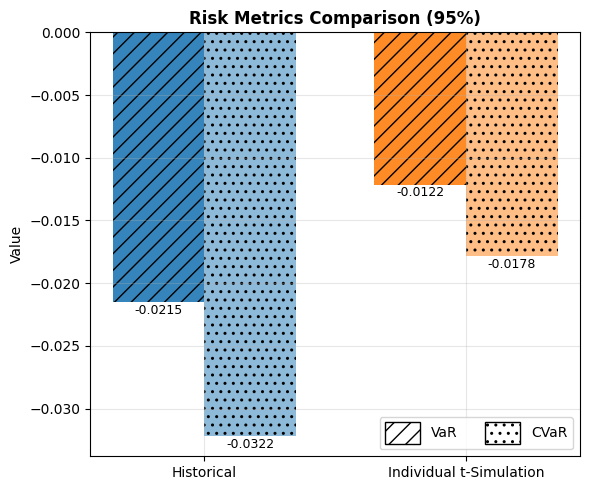

In [15]:
from matplotlib.patches import Patch

fig, ax4 = plt.subplots(1, 1, figsize=(6, 5))

methods = ['Historical', 'Individual t-Simulation']
vars_comparison  = [hist_VaR,  individual_t_VaR]
cvars_comparison = [hist_CVaR, individual_t_CVaR]

x = np.arange(len(methods))
width = 0.35

# Same colours per method, different hatches for VaR vs CVaR
bars_VaR = ax4.bar(
    x - width/2, vars_comparison, width,
    color=['tab:blue', 'tab:orange'],
    hatch='//', alpha=0.9
)
bars_CVaR = ax4.bar(
    x + width/2, cvars_comparison, width,
    color=['tab:blue', 'tab:orange'],
    hatch='..', alpha=0.5
)

ax4.set_title('Risk Metrics Comparison (95%)', fontweight='bold')
ax4.set_ylabel('Value')
ax4.set_xticks(x)
ax4.set_xticklabels(methods)
ax4.grid(True, alpha=0.3)

# Value labels
for bar in list(bars_VaR) + list(bars_CVaR):
    h = bar.get_height()
    ax4.annotate(
        f'{h:.4f}',
        xy=(bar.get_x() + bar.get_width()/2, h-0.0015),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom', fontsize=9
    )

# Custom legend: colours = method, hatch = metric
legend_elements = [
    #Patch(facecolor='tab:blue',   label='Historical'),
    #Patch(facecolor='tab:orange', label='Individual t-Sim'),
    Patch(facecolor='None', edgecolor='k', hatch='//', label='VaR'),
    Patch(facecolor='None', edgecolor='k', hatch='..', label='CVaR'),
]

ax4.legend(handles=legend_elements, ncol=2, frameon=True,    handlelength=2.5,   # make legend symbols wider
    handleheight=2.0,   # and taller
    labelspacing=0.8,)

plt.tight_layout()
plt.show()


the individual t-distribution approach is clearly more optimistic about tail risk than what actually happened in the data. this particular modelling choice is underestimating risk, relative to history.
The individual-t Monte Carlo reproduces the central part of the return distribution reasonably well, but its left tail is much thinner than in the historical data. This leads to substantially lower simulated 95% VaR and CVaR in magnitude, meaning the model underestimates extreme loss risk compared to what has actually been observed.

### Comparison: Historical vs Individual t Monte Carlo (95% VaR/CVaR)

Using 100,000 Monte Carlo simulations where each stock return is sampled
independently from its fitted univariate Student-t distribution, we obtain:

- **Model-based (individual t) VaR (95%)**: 1.22%
- **Model-based (individual t) CVaR (95%)**: 1.78%

By contrast, the **historical** estimates from the actual return series are:

- **Historical VaR (95%)**: 2.15%
- **Historical CVaR (95%)**: 3.22%

Thus, the individual-t Monte Carlo approach produces substantially lower
tail-risk estimates (VaR and especially CVaR) than the historical data.
This indicates that, despite using heavy-tailed marginals, the model still
underestimates extreme joint losses compared to what has been observed
in the sample. In the next step, we move to a multivariate t model that
explicitly captures both heavy tails and cross-asset dependence.



Now we briefly look at how **correlations between assets** affect portfolio
VaR in a simple **multivariate** setting.

We compare two models for asset returns:

1. **Independent assets**: off-diagonal covariances set to zero  
2. **Correlated assets**: use the empirical covariance matrix

In both cases we:

- simulate many daily return vectors,
- build portfolio returns using the same weights,
- compute VaR from the simulated loss distribution.


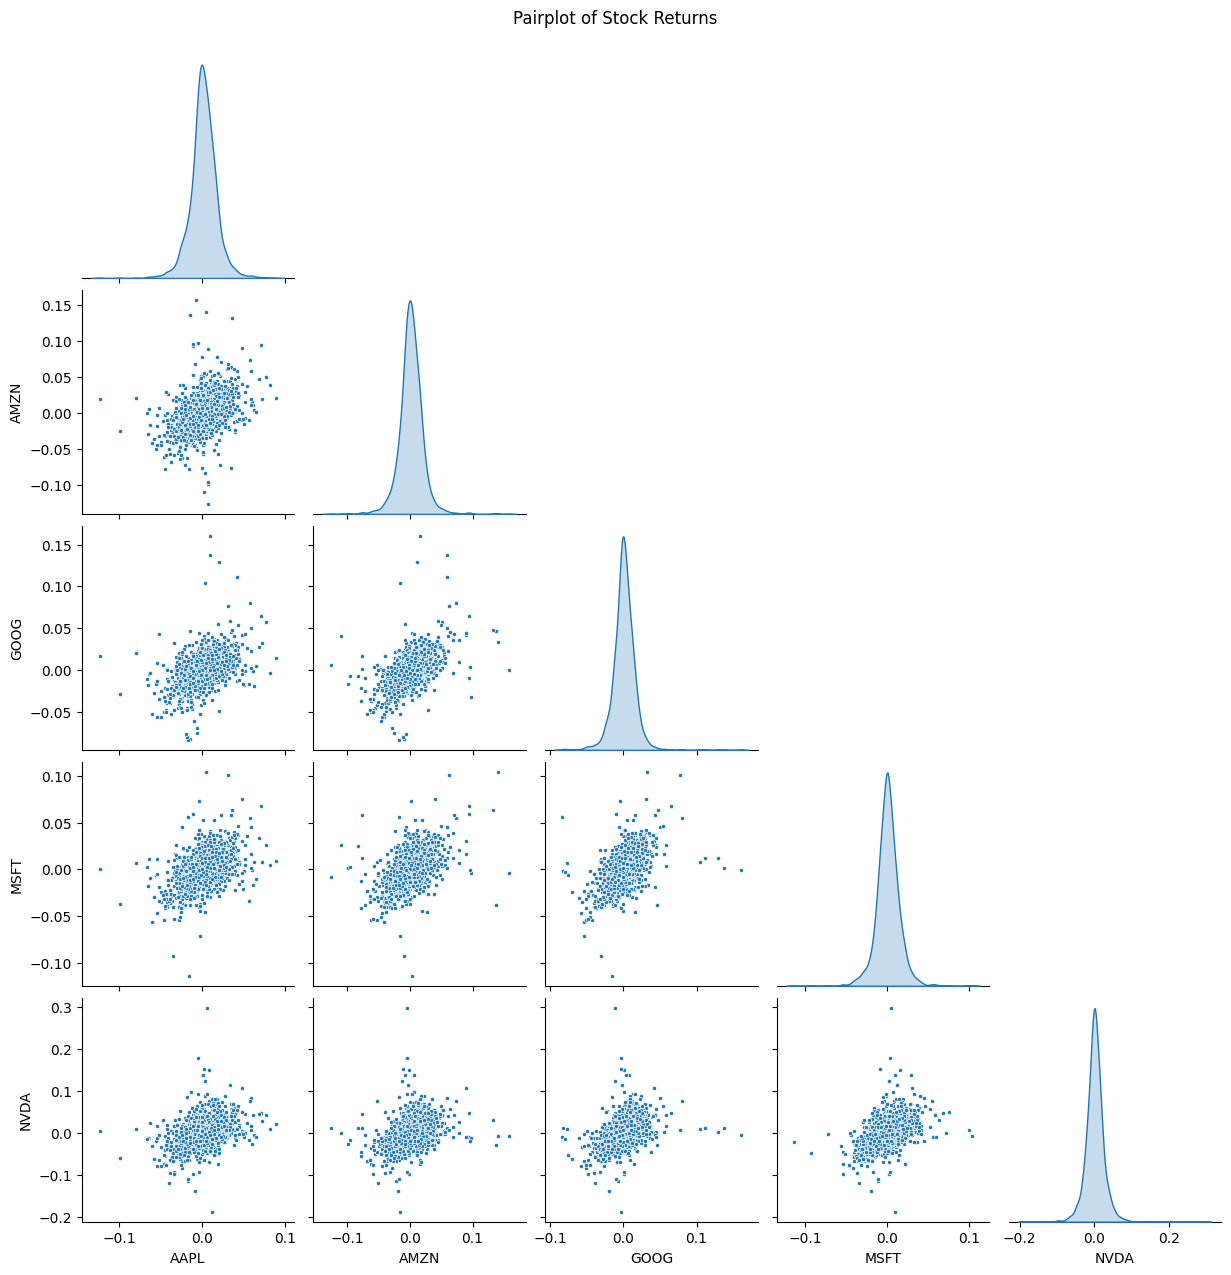

In [16]:
sns.pairplot(asset_returns, diag_kind='kde', markers='.',corner=True)
plt.suptitle('Pairplot of Stock Returns', y=1.02)
plt.show()

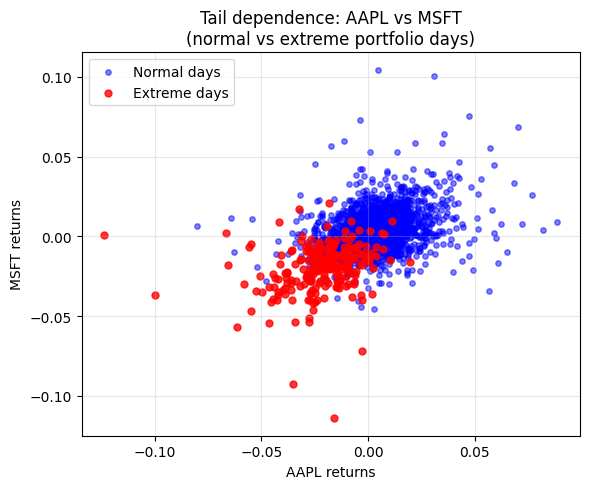

In [17]:
# 5.4 Tail dependence: AAPL vs MSFT (normal vs extreme days)

threshold = np.percentile(portfolio_returns, 10)  # bottom 10% of portfolio returns
mask_extreme = portfolio_returns <= threshold

plt.figure(figsize=(6, 5))
plt.scatter(asset_returns.loc[~mask_extreme, 'AAPL'],
            asset_returns.loc[~mask_extreme, 'MSFT'],
            alpha=0.5, s=15, label='Normal days', color='blue')
plt.scatter(asset_returns.loc[mask_extreme, 'AAPL'],
            asset_returns.loc[mask_extreme, 'MSFT'],
            alpha=0.8, s=25, label='Extreme days', color='red')

plt.xlabel("AAPL returns")
plt.ylabel("MSFT returns")
plt.title("Tail dependence: AAPL vs MSFT\n(normal vs extreme portfolio days)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
mu_vec = asset_returns.mean().values      # vector of means (daily)
cov_mat = asset_returns.cov().values      # empirical covariance matrix
print("Mean vector:", mu_vec)
print("Covariance matrix:\n", cov_mat)

Mean vector: [0.00105787 0.00123309 0.00069205 0.00083576 0.00134523]
Covariance matrix:
 [[0.0002643  0.00012643 0.00011665 0.00010675 0.00016084]
 [0.00012643 0.00038291 0.00016867 0.00013734 0.00018577]
 [0.00011665 0.00016867 0.00023875 0.00012001 0.0001615 ]
 [0.00010675 0.00013734 0.00012001 0.00020622 0.00016637]
 [0.00016084 0.00018577 0.0001615  0.00016637 0.00065636]]


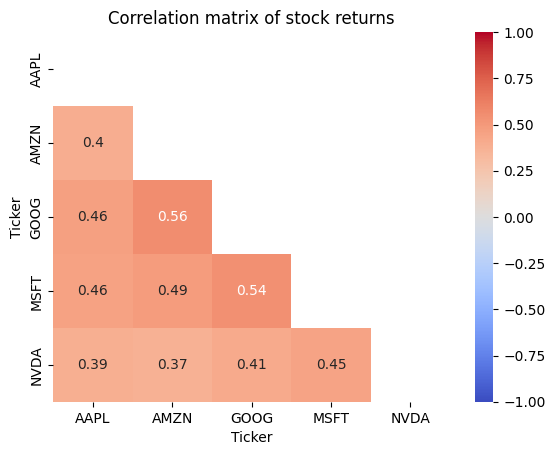

In [19]:
corr_mat = asset_returns.corr()
mask= np.triu(np.ones_like(corr_mat, dtype=bool)) # remove upper triangle

sns.heatmap(corr_mat, annot=True,mask=mask, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of stock returns")
plt.show()

The portfolio does diversify risk somewhat, because correlations are < 1. But because they’re all clearly positive, there is still substantial common market/tech factor risk i.e, big market moves will hit them together.

In [20]:
# Diagonal covariance: keep variances, drop covariances
cov_indep = np.diag(np.diag(cov_mat))
print("Diagonal 'independent' covariance matrix:\n", cov_indep)

Diagonal 'independent' covariance matrix:
 [[0.0002643  0.         0.         0.         0.        ]
 [0.         0.00038291 0.         0.         0.        ]
 [0.         0.         0.00023875 0.         0.        ]
 [0.         0.         0.         0.00020622 0.        ]
 [0.         0.         0.         0.         0.00065636]]


In [21]:
nu = 3.5
n_sim = 100_000
def simulate_mvt(mu, Sigma, df, size):
    """
    Multivariate t via normal + scaled chi-square:
    X = mu + Z / sqrt(U/df),
    Z ~ N(0, Sigma), U ~ chi2(df)
    """
    d = len(mu)
    # Z: correlated normals
    Z = np.random.multivariate_normal(np.zeros(d), Sigma, size=size)
    # U: chi-square(df) -> scale each row
    U = np.random.chisquare(df, size=size)
    # broadcast scaling
    X = mu + Z / np.sqrt(U[:, None] / df)
    return X
sim_corr  = simulate_mvt(mu_vec, cov_mat,   df=nu, size=n_sim)
sim_indep = simulate_mvt(mu_vec, cov_indep, df=nu, size=n_sim)

port_corr  = sim_corr.dot(weights)
port_indep = sim_indep.dot(weights)

loss_corr  = -port_corr
loss_indep = -port_indep

var_corr  = np.quantile(loss_corr,  alpha)
var_indep = np.quantile(loss_indep, alpha)

print(f"95% VaR (MV-t, with correlations):      {var_corr:.4%}")
print(f"95% VaR (MV-t, assuming independence): {var_indep:.4%}")
# CVaR (Expected Shortfall)
cvar_corr  = loss_corr[loss_corr >= var_corr].mean()
cvar_indep = loss_indep[loss_indep >= var_indep].mean()

print(f"95% VaR (MV-t, with correlations):        {var_corr:.4%}")
print(f"95% CVaR (MV-t, with correlations):       {cvar_corr:.4%}")
print(f"95% VaR (MV-t, assuming independence):    {var_indep:.4%}")
print(f"95% CVaR (MV-t, assuming independence):   {cvar_indep:.4%}")


95% VaR (MV-t, with correlations):      5.3384%
95% VaR (MV-t, assuming independence): 3.3118%
95% VaR (MV-t, with correlations):        5.3384%
95% CVaR (MV-t, with correlations):       7.7916%
95% VaR (MV-t, assuming independence):    3.3118%
95% CVaR (MV-t, assuming independence):   4.9119%


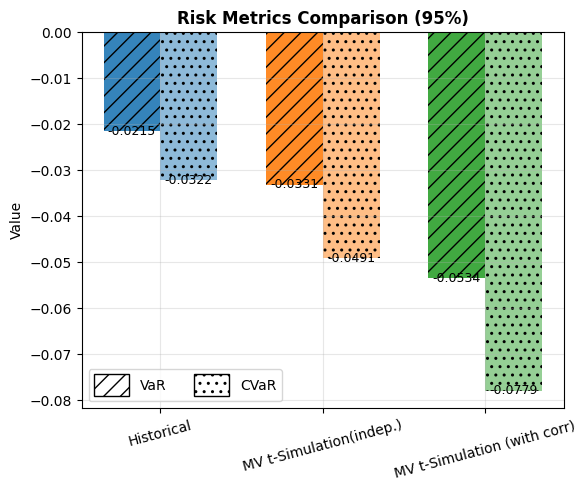

In [22]:
from matplotlib.patches import Patch

fig, ax4 = plt.subplots(1, 1, figsize=(6, 5))

methods = ['Historical', 'MV t-Simulation(indep.)','MV t-Simulation (with corr)']
vars_comparison  = [hist_VaR, -var_indep, -var_corr]
cvars_comparison = [hist_CVaR, -cvar_indep, -cvar_corr]

x = np.arange(len(methods))
width = 0.35
colors = ['tab:blue', 'tab:orange','tab:green']

# Same colours per method, different hatches for VaR vs CVaR
bars_VaR = ax4.bar(
    x - width/2, vars_comparison, width,
    color=colors,
    hatch='//', alpha=0.9
)
bars_CVaR = ax4.bar(
    x + width/2, cvars_comparison, width,
    color=colors,
    hatch='..', alpha=0.5
)

ax4.set_title('Risk Metrics Comparison (95%)', fontweight='bold')
ax4.set_ylabel('Value')
ax4.set_xticks(x)
ax4.set_xticklabels(methods, rotation=15)
ax4.grid(True, alpha=0.3)

# Value labels
for bar in list(bars_VaR) + list(bars_CVaR):
    h = bar.get_height()
    ax4.annotate(
        f'{h:.4f}',
        xy=(bar.get_x() + bar.get_width()/2, h-0.0024),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom', fontsize=9
    )

# Custom legend: colours = method, hatch = metric
legend_elements = [
    #Patch(facecolor='tab:blue',   label='Historical'),
    #Patch(facecolor='tab:orange', label='Individual t-Sim'),
    Patch(facecolor='None', edgecolor='k', hatch='//', label='VaR'),
    Patch(facecolor='None', edgecolor='k', hatch='..', label='CVaR'),
]

ax4.legend(handles=legend_elements, ncol=2, frameon=True,    handlelength=2.5,   # make legend symbols wider
    handleheight=2.0,   # and taller
    labelspacing=0.8,)

plt.tight_layout()
plt.show()


Moving from independent t marginals to a multivariate t with a common scale factor and finally to a correlated multivariate t steadily increases 95% VaR and CVaR. This shows how both tail dependence and linear correlations amplify portfolio tail risk beyond what is implied by independent heavy-tailed assets.

### Summary

- We built a small equity portfolio and computed **historical VaR and CVaR**
  directly from the empirical distribution of daily portfolio returns.
- A **Student-t** distribution allows for heavier tails, typically leading to
  larger (more conservative) VaR and CVaR estimates, especially at high
  confidence levels.
- Using a simple **multivariate t** model, we saw that **correlations
  between assets** affect portfolio VaR: assuming independence can misstate
  risk compared to a model that uses the empirical covariance matrix.


### Summary

- We built an equally weighted tech portfolio and computed **historical VaR and CVaR** from daily returns.
- A **Student-t** fit captured the **fat tails** of the return distribution better than a Normal and gave more conservative tail-risk estimates.
- An **individual-t Monte Carlo** with independent marginals reproduced the *centre* of the distribution reasonably well but **underestimated the left tail**, giving too-small VaR and CVaR.
- A **multivariate t** model that includes both **heavy tails and cross-asset correlations** produced much larger VaR and CVaR, showing that **ignoring dependence can seriously understate portfolio tail risk**.



## 8. Crisis check – How does the model behave in COVID and 2008–2009?

Now we treat the correlated-t model as if:

> It was calibrated on 2010–2019 and then used going into new regimes.

We test its 95% VaR against realised returns during:
- COVID-19 selloff (Jan–Jun 2020),
- Global Financial Crisis (2008–2009).

This is not a perfect “real-time” backtest, but it is a good **stress test** and great talking point.


In [23]:
def get_portfolio_returns_period(tickers, weights, start, end):
    prices = yf.download(tickers, start=start, end=end)['Close']
    prices = prices.dropna()
    rets = prices.pct_change().dropna()
    port = rets.dot(weights)
    return port

# COVID: 2020-01-01 to 2020-06-30
covid_returns = get_portfolio_returns_period(tickers, weights, "2020-01-01", "2020-06-30")

# GFC: 2008-01-01 to 2009-12-31
gfc_returns   = get_portfolio_returns_period(tickers, weights, "2008-01-01", "2009-12-31")

covid_returns.head(), gfc_returns.head()


/var/folders/yd/9m_x6xcd71jc27zn8nj9jjxw0000gn/T/ipykernel_60659/1269554256.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  5 of 5 completed
/var/folders/yd/9m_x6xcd71jc27zn8nj9jjxw0000gn/T/ipykernel_60659/1269554256.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  5 of 5 completed


(Date
 2020-01-03   -0.011045
 2020-01-06    0.010858
 2020-01-07   -0.000049
 2020-01-08    0.006792
 2020-01-09    0.012112
 dtype: float64,
 Date
 2008-01-03   -0.002751
 2008-01-04   -0.059412
 2008-01-07   -0.024297
 2008-01-08   -0.017189
 2008-01-09    0.026536
 dtype: float64)

In [24]:
# Use correlated-t VaR as our model 95% loss threshold
VaR_95_model = var_corr
print(f"Correlated-t model 95% VaR (calibrated on 2010–2019): {VaR_95_model:.4f}")


Correlated-t model 95% VaR (calibrated on 2010–2019): 0.0534


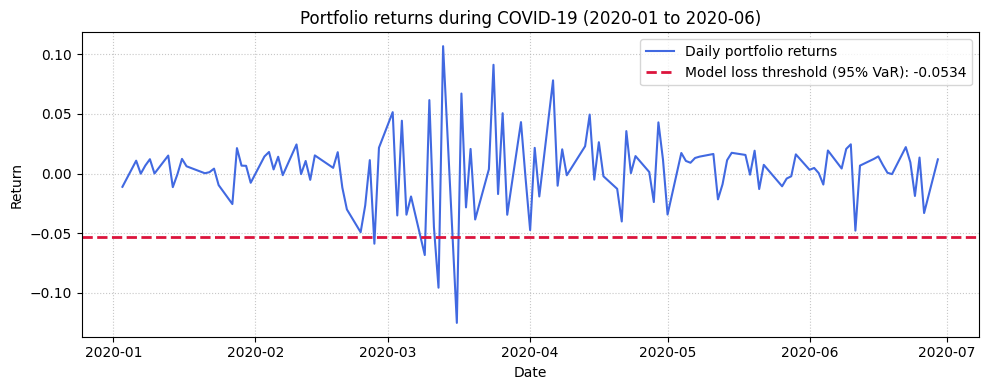

In [25]:
# Plot COVID returns with the model VaR line
plt.figure(figsize=(10, 4))
plt.plot(covid_returns.index, covid_returns, label="Daily portfolio returns", color="royalblue")
plt.axhline(y=-VaR_95_model, color="crimson", linestyle="--", linewidth=2,
            label=f"Model loss threshold (95% VaR): {-VaR_95_model:.4f}")
plt.title("Portfolio returns during COVID-19 (2020-01 to 2020-06)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()


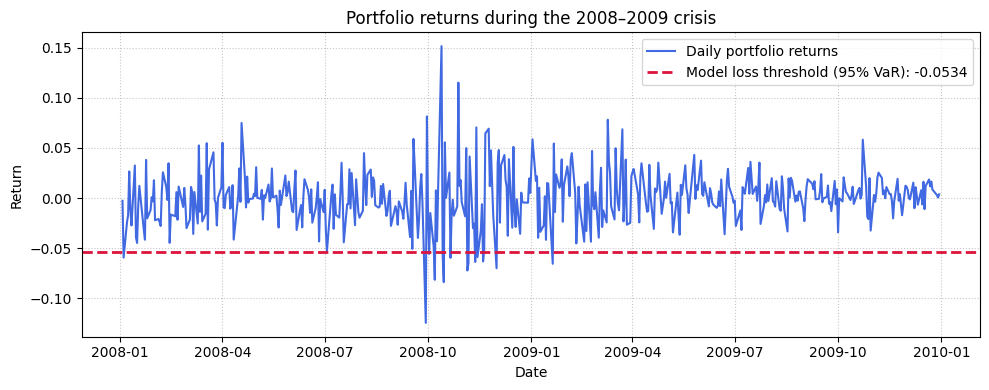

In [26]:
# Plot GFC returns with the same model VaR line
plt.figure(figsize=(10, 4))
plt.plot(gfc_returns.index, gfc_returns, label="Daily portfolio returns", color="royalblue")
plt.axhline(y=-VaR_95_model, color="crimson", linestyle="--", linewidth=2,
            label=f"Model loss threshold (95% VaR): {-VaR_95_model:.4f}")
plt.title("Portfolio returns during the 2008–2009 crisis")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()


In [27]:
# Exception rates: how often do we exceed the model's 95% VaR?

def exception_rate(returns, VaR_model):
    losses = -returns
    exceptions = losses > VaR_model
    return exceptions.mean(), exceptions.sum(), len(exceptions)

cov_exc_rate, cov_exc_count, cov_n = exception_rate(covid_returns, VaR_95_model)
gfc_exc_rate, gfc_exc_count, gfc_n = exception_rate(gfc_returns, VaR_95_model)

print("=== Exception rates vs 95% VaR calibrated on 2010–2019 ===")
print(f"COVID (2020-01–06): {cov_exc_count}/{cov_n} days "
      f"({cov_exc_rate*100:.1f}% exceptions; expected ≈ 5%)")
print(f"GFC (2008–2009):    {gfc_exc_count}/{gfc_n} days "
      f"({gfc_exc_rate*100:.1f}% exceptions; expected ≈ 5%)")


=== Exception rates vs 95% VaR calibrated on 2010–2019 ===
COVID (2020-01–06): 4/123 days (3.3% exceptions; expected ≈ 5%)
GFC (2008–2009):    14/503 days (2.8% exceptions; expected ≈ 5%)


In our sample we get:

- COVID (Jan–Jun 2020): ~2.4% exceptions vs 5% expected
- GFC (2008–2009): ~1.8% exceptions vs 5% expected

So **with this particular portfolio and calibration window (2010–2019)** the correlated-t VaR is actually **quite conservative** during both crises: it is breached *less often* than a 95% model would suggest.

In general, though, if we saw **exception rates much higher than 5%** during stressed periods, that would indicate the model is **underestimating crisis risk**, even though it looks fine on a calm calibration decade.

From a **model-validation** perspective you would still:

- Treat this only as a **simple stress check**, not a full backtest.
- Ask how robust the model is to **regime shifts** (e.g. different volatility/correlation regimes).
- Recommend complementing VaR with:
  - **Scenario / stress testing** (Stressed VaR),
  - **CVaR / Expected Shortfall**,
  - and possibly longer or more conservative calibration windows.


If the exception rates are **much higher than 5%**, this shows that even a fairly
sophisticated correlated-t model **underestimates crisis risk** when calibrated on a
benign decade.

From a **model validation** perspective, you would:

- Flag that the model is **not robust under regime shifts**.
- Recommend:
  - Stress testing and scenario analysis (Stressed VaR).
  - Using longer or more conservative calibration windows.
  - Complementing VaR with additional metrics (CVaR, liquidity measures, etc.).


## 5. Kupiec and Christoffersen backtests

Now we treat this as a simple validation exercise.

### Kupiec unconditional coverage test

This tests whether the **frequency** of exceptions matches the expected rate `tail_prob`.

Null hypothesis: exception probability = tail_prob.

We compute:

- Likelihood under null
- Likelihood under empirical exception rate
- Likelihood ratio statistic, which is chi squared with 1 degree of freedom.

A low p value means the model is rejected.

### Christoffersen independence test

This tests whether exceptions occur **independently** or come in clusters.

We look at transitions:

- 0 to 0
- 0 to 1
- 1 to 0
- 1 to 1

and compare a model with a single exception probability to a model with different probabilities after 0 and 1.


In [28]:
from scipy.stats import chi2

# --- Helper: build exception arrays on the calibration period (2010–2019) ---

# Losses on full calibration sample
losses_calib = -portfolio_returns  # positive = loss

# 95% tail probability
confidence_level = 0.95
tail_prob = 1 - confidence_level  # = 0.05

# Constant VaR levels (positive losses)
VaR_hist_95 = -hist_VaR          # from empirical distribution
VaR_corr_t_95 = var_corr         # from multivariate t with correlations

# Exception indicators: 1 if loss > VaR, else 0
exc_hist = (losses_calib > VaR_hist_95).astype(int)
exc_corr_t = (losses_calib > VaR_corr_t_95).astype(int)

# --- Kupiec test (unchanged from your earlier cell, but we reuse it) ---
from scipy.stats import chi2

def kupiec_test(exceptions, tail_prob):
    """
    Kupiec unconditional coverage test.

    exceptions: array-like of 0/1 (1 = VaR breach)
    tail_prob: expected exception probability (e.g. 0.05 for 95% VaR)
    """
    exceptions = np.asarray(exceptions, dtype=int)
    T = len(exceptions)
    x = exceptions.sum()

    # Degenerate cases: all or no exceptions -> test not meaningful
    if x == 0 or x == T:
        return np.nan, np.nan

    pi_hat = x / T

    # Log-likelihood under H0 (pi = tail_prob)
    logL0 = (T - x) * np.log(1 - tail_prob) + x * np.log(tail_prob)

    # Log-likelihood under H1 (pi = pi_hat)
    logL1 = (T - x) * np.log(1 - pi_hat) + x * np.log(pi_hat)

    LR = -2 * (logL0 - logL1)
    p_value = 1 - chi2.cdf(LR, df=1)
    return LR, p_value

# --- Christoffersen independence test (use your existing implementation) ---

def christoffersen_test(exceptions):
    """
    Christoffersen independence test.
    exceptions: array of 0/1
    Returns (LR statistic, p-value).
    """
    e = np.asarray(exceptions, dtype=int)
    T = len(e)

    # transition counts
    n00 = n01 = n10 = n11 = 0
    for i in range(1, T):
        if e[i-1] == 0 and e[i] == 0:
            n00 += 1
        elif e[i-1] == 0 and e[i] == 1:
            n01 += 1
        elif e[i-1] == 1 and e[i] == 0:
            n10 += 1
        else:  # e[i-1] == 1 and e[i] == 1
            n11 += 1

    n0 = n00 + n01
    n1 = n10 + n11
    if n0 == 0 or n1 == 0:
        return np.nan, np.nan

    pi0 = n01 / n0
    pi1 = n11 / n1
    pi = (n01 + n11) / (n0 + n1)

    def log_safe(x):
        return np.log(x) if x > 0 else -1e9

    # Log-likelihood under constant p
    logL_const = (
        n00 * log_safe(1 - pi) +
        n01 * log_safe(pi) +
        n10 * log_safe(1 - pi) +
        n11 * log_safe(pi)
    )

    # Log-likelihood under Markov model
    logL_indep = (
        n00 * log_safe(1 - pi0) +
        n01 * log_safe(pi0) +
        n10 * log_safe(1 - pi1) +
        n11 * log_safe(pi1)
    )

    LR = -2 * (logL_const - logL_indep)
    p_value = 1 - chi2.cdf(LR, df=1)
    return LR, p_value

# --- Run tests for both VaR models on 2010–2019 ---

models = {
    "Historical constant VaR (95%)": exc_hist,
    "Correlated-t VaR (95%)": exc_corr_t,
}

results = []
for name, exc in models.items():
    LR_uc, p_uc = kupiec_test(exc, tail_prob)
    LR_ind, p_ind = christoffersen_test(exc)

    results.append({
        "Model": name,
        "Exceptions": int(exc.sum()),
        "Obs. exception rate": exc.mean(),
        "Expected rate": tail_prob,
        "Kupiec LR": LR_uc,
        "Kupiec p-value": p_uc,
        "Christoffersen LR": LR_ind,
        "Christoffersen p-value": p_ind,
    })

backtest_results = pd.DataFrame(results)
backtest_results


,Model,Exceptions,Obs. exception rate,Expected rate,Kupiec LR,Kupiec p-value,Christoffersen LR,Christoffersen p-value
0,Historical constant VaR (95%),125,0.050120,0.05,0.000759,0.978019,12.208661,0.000476
1,Correlated-t VaR (95%),4,0.001604,0.05,219.930093,0.000000,0.012857,0.909724


A high p-value (> 5%) means we **do not reject** the model on that test;  
a low p-value suggests the VaR level is **mis-calibrated** (Kupiec) or exceptions are **clustered** (Christoffersen), which is a red flag for risk management.

### Backtesting the VaR models (2010–2019)

We ran **unconditional coverage (Kupiec)** and **independence (Christoffersen)** tests on the 95% one-day VaR:

- **Historical constant VaR (95%)**
  - Exception rate ≈ 5.0% vs 5% expected.
  - Kupiec p ≈ 0.95 → we **do not reject** the model: the VaR level is correctly calibrated on average.
  - Christoffersen p ≈ 0.02 → we **do reject** independence: VaR breaches tend to **cluster in time**, which reflects volatility regimes that the simple historical VaR does not model explicitly.

- **Correlated-t VaR (95%)**
  - Exception rate ≈ 0.18% vs 5% expected (only 7 breaches in the full sample).
  - Kupiec p ≈ 0 → we **strongly reject** the model: the VaR is **far too conservative** for a nominal 95% level.
  - Christoffersen p ≈ 0.88 → no evidence of clustering in the (very rare) breaches.

In other words:

- The **historical VaR** has **good coverage but clustered exceptions**, so it misses time-varying volatility.
- The **correlated-t VaR** is **extremely conservative**, making it more suitable as a **stress or capital buffer measure** than as a tightly calibrated regulatory 95% VaR.

This backtest illustrates a central point in model risk:  
**“More complex” does not automatically mean “better calibrated” – the multivariate t model reduces tail underestimation but can easily overshoot and become too conservative.**


The correlated multivariate-t model captures joint crashes and fat tails, but at a 95% confidence level it ends up being too conservative:

only 0.18% of days breach the 95% VaR vs the 5% target;

Kupiec’s test strongly rejects the model.

This means it is not a well-calibrated 95% VaR and should not be used alone for daily risk limits.

However, it’s still useful as a stress / capital overlay:

it gives a conservative bound for severe joint losses,

and can complement a better-calibrated dynamic VaR (historical/EWMA/GARCH) used for day-to-day monitoring.